In [1]:
from __future__ import print_function

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import json
import os
import mne
import copy

import ecogtools

In [2]:
%matplotlib inline

# Set up

In [22]:
patient_num = "2002"

channels = ['RTG22', 'RTG23', 'RTG24', 'RTG30', 'RTG31', 'RTG32', 'RTG38', 'RTG39', 'RTG40', 'RTG46', 'RTG47', 'RTG48', 'RTG57']

In [23]:
data = ecogtools.faces_task(patient_num)

Opening raw data file /Users/atheliarosapaulli/Desktop/pearson lab/Ecog_data_analysis/patient_2002/john_2002.fif...
This filename (/Users/atheliarosapaulli/Desktop/pearson lab/Ecog_data_analysis/patient_2002/john_2002.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz


/Users/atheliarosapaulli/Desktop/pearson lab/ecogtools/ecogtools.py:34: RuntimeWarning: This filename (/Users/atheliarosapaulli/Desktop/pearson lab/Ecog_data_analysis/patient_2002/john_2002.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  self.phys = mne.io.read_raw_fif(self.ecogfile, preload=False)


Isotrak not found
    Range : 0 ... 4157999 =      0.000 ...  2078.999 secs
Ready.
Opening raw data file /Users/atheliarosapaulli/Desktop/pearson lab/Ecog_data_analysis/patient_2002/john_2002-1.fif...
Isotrak not found
    Range : 4158000 ... 8315999 =   2079.000 ...  4157.999 secs
Ready.
Opening raw data file /Users/atheliarosapaulli/Desktop/pearson lab/Ecog_data_analysis/patient_2002/john_2002-2.fif...
Isotrak not found
    Range : 8316000 ... 12473999 =   4158.000 ...  6236.999 secs
Ready.
Opening raw data file /Users/atheliarosapaulli/Desktop/pearson lab/Ecog_data_analysis/patient_2002/john_2002-3.fif...
Isotrak not found
    Range : 12474000 ... 14399951 =   6237.000 ...  7199.975 secs
Ready.


In [24]:
# Get the times for task from behavioral data
tmin = int(data.trig_and_behav.loc[0, 'trigger_time']-10)
tmax = int(data.trig_and_behav.loc[59, 'trigger_time']+10)

# Get only physiology data that we actually want to look at for task.
data.phys.crop(tmin=tmin, tmax=tmax)

<Raw  |  john_2002-2.fif, n_channels x n_times : 129 x 306001 (153.0 sec), ~222 kB, data not loaded>

In [25]:
# Load data and pick only channels that we care about.
data.phys.load_data()
data.phys.pick_channels(channels)

Reading 0 ... 306000  =      0.000 ...   153.000 secs...


<Raw  |  john_2002-2.fif, n_channels x n_times : 13 x 306001 (153.0 sec), ~30.4 MB, data loaded>

In [26]:
# Create epochs object for trial viz and averaging.
data.initialize_epochs_object(channels, tmin=-6., tmax=6., baseline=None)

156 matching events found
0 projection items activated
Loading data for 156 events and 24001 original time points ...
95 bad epochs dropped


In [27]:
# Create evoked for Question Start
sad_neutral_qs_evoked = data.create_evoked("sad-neutral/quest_start")
happy_qs_evoked = data.create_evoked("happy/quest_start")
QS_evoked = mne.combine_evoked([sad_neutral_qs_evoked, happy_qs_evoked], weights=[1, -1])

# Create evoked for Time of Response
sad_neutral_tr_evoked = data.create_evoked("sad-neutral/time_of_resp")
happy_tr_evoked = data.create_evoked("happy/time_of_resp")
TR_evoked = mne.combine_evoked([sad_neutral_tr_evoked, happy_tr_evoked], weights=[1, -1])

In [28]:
# BANDPASS FILTER: Define frequencies, cycles and bandwidth
freqs = np.linspace(80, 150, 25)
n_cycles = freqs/2.0
time_bandwidth = 8.0

In [ ]:
# Calculate power for Question Start high gamma ()
sad_neutral_qs_power = mne.time_frequency.tfr_multitaper(data.epochs['sad-neutral/quest_start'], freqs=freqs, n_cycles=n_cycles,
                       time_bandwidth=time_bandwidth, return_itc=False)
happy_qs_power = mne.time_frequency.tfr_multitaper(data.epochs['happy/quest_start'], freqs=freqs, n_cycles=n_cycles,
                       time_bandwidth=time_bandwidth, return_itc=False)
QS_power = data.compute_diff_power(sad_neutral_qs_power, happy_qs_power)

# Calculate power for Time of Response high gamma
sad_neutral_tr_power = mne.time_frequency.tfr_multitaper(data.epochs['sad-neutral/time_of_resp'], freqs=freqs, n_cycles=n_cycles,
                       time_bandwidth=time_bandwidth, return_itc=False)
happy_tr_power = mne.time_frequency.tfr_multitaper(data.epochs['happy/time_of_resp'], freqs=freqs, n_cycles=n_cycles,
                       time_bandwidth=time_bandwidth, return_itc=False)
TR_power = data.compute_diff_power(sad_neutral_tr_power, happy_tr_power)

In [ ]:
# Copy data class for Filter-Hilbert Transform
data_filt = copy.copy(data)
data_filt.phys.filter(80, 160)
data_filt.phys.apply_hilbert(envelope=True)

In [ ]:
# New epochs object for filtered/HT data
data_filt.initialize_epochs_object(channels, tmin=-6., tmax=6., baseline=None)

In [ ]:
# Evoked Power for Question Start sad-neutral/happy
sad_neutral_qs_filt = data_filt.create_evoked("sad-neutral/quest_start")
happy_qs_filt = data_filt.create_evoked("happy/quest_start")
QS_filt = mne.combine_evoked([sad_neutral_qs_filt, happy_qs_filt], weights = [1, -1])

# Evoked Power for Time of Response sad-neutral/happy
sad_neutral_tr_filt = data_filt.create_evoked("sad-neutral/time_of_resp")
happy_tr_filt = data_filt.create_evoked("happy/time_of_resp")
TR_filt = mne.combine_evoked([sad_neutral_tr_filt, happy_tr_filt], weights = [1, -1])

In [ ]:
# Define frequencies, cycles and bandwidth
freqs = np.geomspace(1, 80, 25)
n_cycles = freqs/2.0
print(freqs)

In [ ]:
# Calculate power for Question Start low freq
low_sad_neutral_qs_power = mne.time_frequency.tfr_morlet(data.epochs['sad-neutral/quest_start'], freqs=freqs, n_cycles=n_cycles,
                    return_itc=False)
low_happy_qs_power = mne.time_frequency.tfr_morlet(data.epochs['happy/quest_start'], freqs=freqs, n_cycles=n_cycles,
                    return_itc=False)
low_QS_power = data.compute_diff_power(low_sad_neutral_qs_power, low_happy_qs_power)

# Calculate power for Time of Response low freq
low_sad_neutral_tr_power = mne.time_frequency.tfr_morlet(data.epochs['sad-neutral/time_of_resp'], freqs=freqs, n_cycles=n_cycles,
                    return_itc=False)
low_happy_tr_power = mne.time_frequency.tfr_morlet(data.epochs['happy/time_of_resp'], freqs=freqs, n_cycles=n_cycles,
                    return_itc=False)
low_TR_power = data.compute_diff_power(low_sad_neutral_tr_power, low_happy_tr_power)

In [ ]:
# Copy data class for Filter-Hilbert Transform
data_filt = copy.copy(data)
data_filt.phys.filter(1, 80)
data_filt.phys.apply_hilbert(envelope=True)

In [16]:
# New epochs object for filtered/HT data
data_filt.initialize_epochs_object(channels, tmin=-6., tmax=6., baseline=None)

156 matching events found
0 projection items activated
Loading data for 156 events and 24001 original time points ...
95 bad epochs dropped


# Evoked Power for Question Start sad-neutral/happy
low_sad_neutral_qs_filt = data_filt.create_evoked("sad-neutral/quest_start")
low_happy_qs_filt = data_filt.create_evoked("happy/quest_start")
low_QS_filt = mne.combine_evoked([sad_neutral_qs_filt, happy_qs_filt], weights = [1, -1])

# Evoked Power for Time of Response sad-neutral/happy
low_sad_neutral_tr_filt = data_filt.create_evoked("sad-neutral/time_of_resp")
low_happy_tr_filt = data_filt.create_evoked("happy/time_of_resp")
low_TR_filt = mne.combine_evoked([sad_neutral_tr_filt, happy_tr_filt], weights = [1, -1])

# PLOTTING


In [ ]:
# Choose channels and define parameters for all functions
channel_of_interest = "RTG31"
index = channels.index(channel_of_interest)
COI = [index]

# Times and baseline periods for QS/TR
# Times and baseline periods for QS/TR
QS_times = {"tmin":-1., "tmax":4.}
TR_times = {"tmin":-4., "tmax":1.}
QS_baseline = (-1., 0)
TR_baseline = (0., .5)

## Loop through plots 

Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)


NameError: name 'sad_neutral_tr_filt' is not defined

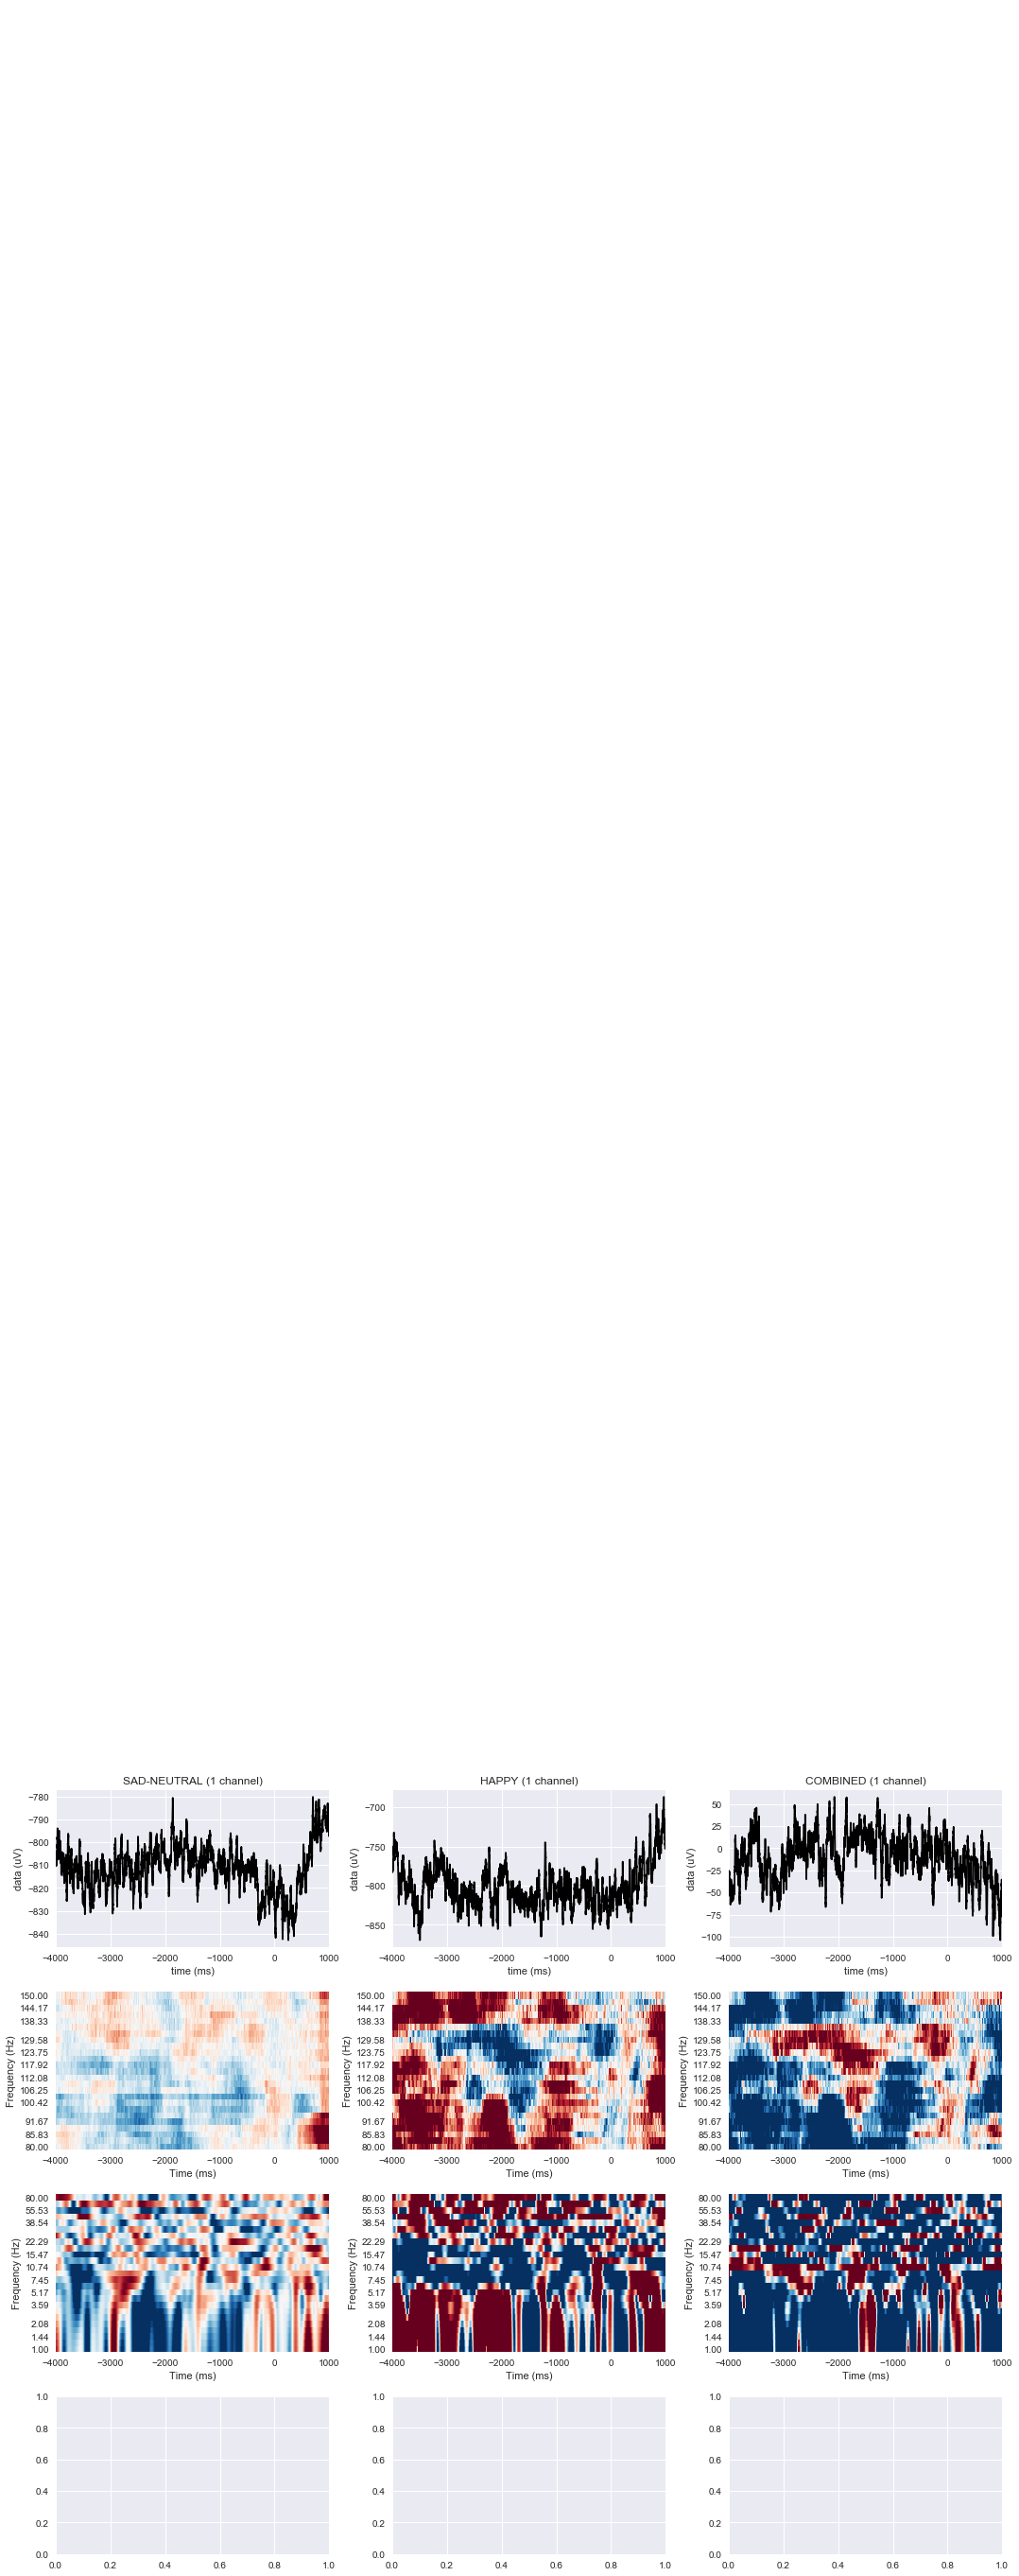

In [18]:
# Times and baseline periods for TR

for channel in channels:
    channel_of_interest = channel
    index = channels.index(channel_of_interest)
    COI = [index]
    
    f, axes = plt.subplots(4, 3, figsize=(15,12))

    sad_neutral_tr_evoked.crop(**TR_times).plot(COI, axes=axes[0,0], show=False, titles="SAD-NEUTRAL");
    happy_tr_evoked.crop(**TR_times).plot(COI, axes=axes[0, 1], show=False, titles="HAPPY");
    TR_evoked.crop(**TR_times).plot(COI, axes=axes[0, 2], show=False, titles="COMBINED");

    sad_neutral_tr_power.plot(COI, baseline=TR_baseline, mode='ratio', dB=True, vmin=-5., vmax=5., **TR_times, axes=axes[1, 0], show=False, colorbar=False);
    happy_tr_power.plot(COI, baseline=TR_baseline, mode='ratio', dB=True, vmin=-5., vmax=5., **TR_times, axes=axes[1, 1], show=False, colorbar=False);
    TR_power.plot(COI, baseline=TR_baseline, mode='ratio', dB=True, vmin=-5., vmax=5., **TR_times, axes=axes[1, 2], show=False, colorbar=False);
    
    low_sad_neutral_tr_power.plot(COI, baseline=TR_baseline, mode='ratio', dB=True, vmin=-5., vmax=5., **TR_times, axes=axes[2, 0], show=False, colorbar=False);
    low_happy_tr_power.plot(COI, baseline=TR_baseline, mode='ratio', dB=True, vmin=-5., vmax=5., **TR_times, axes=axes[2, 1], show=False, colorbar=False);
    low_TR_power.plot(COI, baseline=TR_baseline, mode='ratio', dB=True, vmin=-5., vmax=5., **TR_times, axes=axes[2, 2], show=False, colorbar=False);
    
    sad_neutral_tr_filt.crop(**TR_times).plot(COI, axes=axes[3, 0], show=False);
    happy_tr_filt.crop(**TR_times).plot(COI, axes=axes[3, 1], show=False);
    TR_filt.crop(**TR_times).plot(COI, axes=axes[3, 2], show=False);

    f.savefig("patient_"+patient_num+'/Faces_TR_plots_lowfreq/' + channel_of_interest + ".png")



Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)


NameError: name 'sad_neutral_qs_filt' is not defined

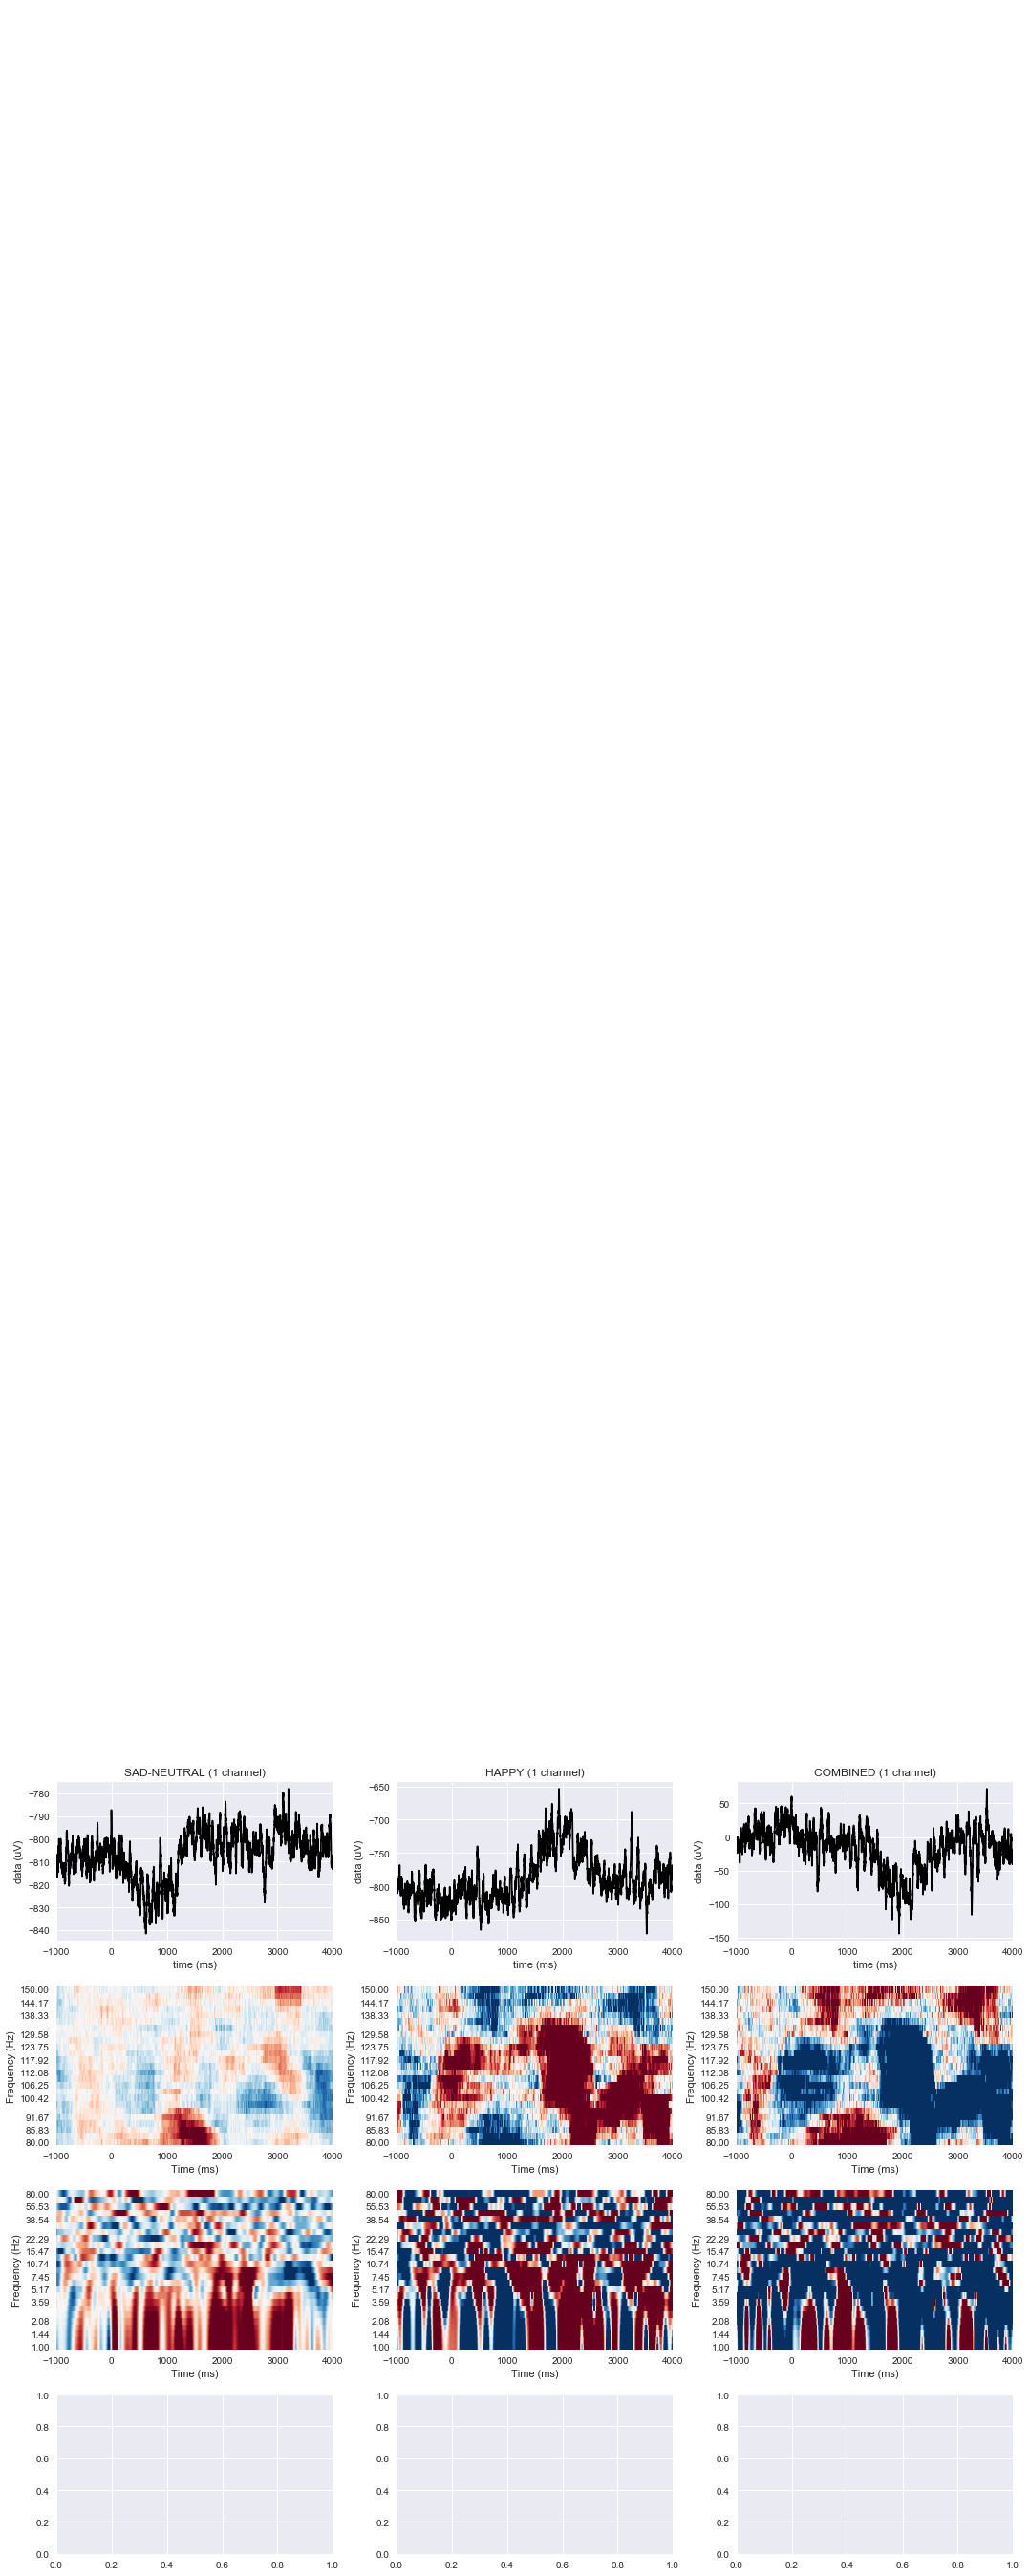

In [19]:
# Times and baseline periods for QS

for channel in channels:
    channel_of_interest = channel
    index = channels.index(channel_of_interest)
    COI = [index]
    
    f, axes = plt.subplots(4, 3, figsize=(15,12))

    sad_neutral_qs_evoked.crop(**QS_times).plot(COI, axes=axes[0,0], show=False, titles="SAD-NEUTRAL");
    happy_qs_evoked.crop(**QS_times).plot(COI, axes=axes[0, 1], show=False, titles="HAPPY");
    QS_evoked.crop(**QS_times).plot(COI, axes=axes[0, 2], show=False, titles="COMBINED");

    sad_neutral_qs_power.plot(COI, baseline=QS_baseline, mode='ratio', dB=True, vmin=-5., vmax=5., **QS_times, axes=axes[1, 0], show=False, colorbar=False);
    happy_qs_power.plot(COI, baseline=QS_baseline, mode='ratio', dB=True, vmin=-5., vmax=5., **QS_times, axes=axes[1, 1], show=False, colorbar=False);
    QS_power.plot(COI, baseline=QS_baseline, mode='ratio', dB=True, vmin=-5., vmax=5., **QS_times, axes=axes[1, 2], show=False, colorbar=False);

    low_sad_neutral_qs_power.plot(COI, baseline=QS_baseline, mode='ratio', dB=True, vmin=-5., vmax=5., **QS_times, axes=axes[2, 0], show=False, colorbar=False);
    low_happy_qs_power.plot(COI, baseline=QS_baseline, mode='ratio', dB=True, vmin=-5., vmax=5., **QS_times, axes=axes[2, 1], show=False, colorbar=False);
    low_QS_power.plot(COI, baseline=QS_baseline, mode='ratio', dB=True, vmin=-5., vmax=5., **QS_times, axes=axes[2, 2], show=False, colorbar=False);    
        
    sad_neutral_qs_filt.crop(**QS_times).plot(COI, axes=axes[3, 0], show=False);
    happy_qs_filt.crop(**QS_times).plot(COI, axes=axes[3, 1], show=False);
    QS_filt.crop(**QS_times).plot(COI, axes=axes[3, 2], show=False);

    f.savefig("patient_"+patient_num+'/Faces_QS_plots_lowfreq/' + channel_of_interest + ".png")

